In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, auc, roc_curve, average_precision_score, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
sns.set()

Using TensorFlow backend.


# Random Forest Classifier -  60 genes from literature (no clinical) -smote binary

## Helper functions

In [2]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Get accuracy
    right = np.diagonal(cm).sum()
    acc = float(right)/cm.sum()
    print("Accuracy is {} %".format(acc*100))
    tpr = float(cm[1,1])/cm[1,:].sum()
    fpr = float(cm[0,1])/cm[0,:].sum()
    precision = float(cm[1,1])/cm[:,1].sum()
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return acc, tpr, fpr, precision

# Data preprocessing

In [3]:
df = pd.read_csv('cleaned.csv')

In [4]:
df.head()

,Unnamed: 0,case_id,submitter_id,tumor_stage,age_at_diagnosis,prior_malignancy,race,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
0,0,4d0fec97-e024-4608-a0cc-426a3decc7b1,TCGA-AR-A252_exposure,stage i,50.989041,0,white,2608.0,289.0,1661.0,...,15.0,3.0,0.0,0.0,1.0,0.0,75.0,1.0,2.0,0.0
1,1,bb8d42d3-ad65-4d88-ae1d-f9aadfc7962d,TCGA-AO-A1KS_exposure,stage iia,69.123288,0,white,5789.0,34.0,2538.0,...,41.0,1.0,0.0,0.0,5.0,1.0,24.0,0.0,2.0,0.0
2,2,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,white,4544.0,1881.0,1565.0,...,26.0,3.0,0.0,0.0,0.0,0.0,16.0,1.0,3.0,0.0
3,3,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,white,676.0,41.0,3732.0,...,14.0,1.0,0.0,0.0,3.0,1.0,61.0,3.0,6.0,0.0
4,4,1285eb55-415c-494a-aa58-936f0427cdd0,TCGA-V7-A7HQ_exposure,stage iiia,75.846575,0,black or african american,2299.0,5.0,708.0,...,4.0,0.0,0.0,0.0,0.0,0.0,208.0,0.0,19.0,0.0


In [5]:
df['prior_malignancy'].value_counts()

0    1096
1      68
Name: prior_malignancy, dtype: int64

In [6]:
df=df.drop(['Unnamed: 0'],axis=1)
df.head()

,case_id,submitter_id,tumor_stage,age_at_diagnosis,prior_malignancy,race,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,...,ENSG00000281903.1,ENSG00000281904.1,ENSG00000281905.1,ENSG00000281906.1,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1
0,4d0fec97-e024-4608-a0cc-426a3decc7b1,TCGA-AR-A252_exposure,stage i,50.989041,0,white,2608.0,289.0,1661.0,2081.0,...,15.0,3.0,0.0,0.0,1.0,0.0,75.0,1.0,2.0,0.0
1,bb8d42d3-ad65-4d88-ae1d-f9aadfc7962d,TCGA-AO-A1KS_exposure,stage iia,69.123288,0,white,5789.0,34.0,2538.0,2572.0,...,41.0,1.0,0.0,0.0,5.0,1.0,24.0,0.0,2.0,0.0
2,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,white,4544.0,1881.0,1565.0,1356.0,...,26.0,3.0,0.0,0.0,0.0,0.0,16.0,1.0,3.0,0.0
3,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,white,676.0,41.0,3732.0,3155.0,...,14.0,1.0,0.0,0.0,3.0,1.0,61.0,3.0,6.0,0.0
4,1285eb55-415c-494a-aa58-936f0427cdd0,TCGA-V7-A7HQ_exposure,stage iiia,75.846575,0,black or african american,2299.0,5.0,708.0,388.0,...,4.0,0.0,0.0,0.0,0.0,0.0,208.0,0.0,19.0,0.0


In [7]:
df['race'].value_counts()

white                               832
black or african american           180
not reported                         94
asian                                57
american indian or alaska native      1
Name: race, dtype: int64

In [9]:
df = df[df['race'] != 'american indian or alaska native']
df['race'].value_counts()

white                        832
black or african american    180
not reported                  94
asian                         57
Name: race, dtype: int64

In [11]:
df = pd.get_dummies(df, columns=['race'], prefix='race')

In [12]:
df.head()

,case_id,submitter_id,tumor_stage,age_at_diagnosis,prior_malignancy,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,...,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1,race_asian,race_black or african american,race_not reported,race_white
0,4d0fec97-e024-4608-a0cc-426a3decc7b1,TCGA-AR-A252_exposure,stage i,50.989041,0,2608.0,289.0,1661.0,2081.0,684.0,...,1.0,0.0,75.0,1.0,2.0,0.0,0,0,0,1
1,bb8d42d3-ad65-4d88-ae1d-f9aadfc7962d,TCGA-AO-A1KS_exposure,stage iia,69.123288,0,5789.0,34.0,2538.0,2572.0,1292.0,...,5.0,1.0,24.0,0.0,2.0,0.0,0,0,0,1
2,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,4544.0,1881.0,1565.0,1356.0,294.0,...,0.0,0.0,16.0,1.0,3.0,0.0,0,0,0,1
3,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,stage iiia,68.819178,0,676.0,41.0,3732.0,3155.0,1010.0,...,3.0,1.0,61.0,3.0,6.0,0.0,0,0,0,1
4,1285eb55-415c-494a-aa58-936f0427cdd0,TCGA-V7-A7HQ_exposure,stage iiia,75.846575,0,2299.0,5.0,708.0,388.0,93.0,...,0.0,0.0,208.0,0.0,19.0,0.0,0,1,0,0


In [13]:
df_literature_genes = pd.read_csv('literature_genes.csv')

In [14]:
df_literature_genes.head()

,Name,Code
0,IDH2 | isocitrate dehydrogenase 2,ENSG00000182054
1,FLJ10540 | hypothetical protein,ENSG00000138180
2,KNSL1 | kinesin-like 1,ENSG00000138160
3,ANKT | nucleolar protein ANKT,ENSG00000137804
4,PRO2000 | PRO2000 protein,ENSG00000156802


In [15]:
good_codes = []
for code in df_literature_genes['Code']:
    good_code = df.columns[df.columns.str.startswith(code)].values[0]
    good_codes.append(good_code)
good_codes

['ENSG00000182054.8',
 'ENSG00000138180.14',
 'ENSG00000138160.5',
 'ENSG00000137804.11',
 'ENSG00000156802.11',
 'ENSG00000227799.1',
 'ENSG00000051180.15',
 'ENSG00000175063.15',
 'ENSG00000011426.9',
 'ENSG00000123737.11',
 'ENSG00000087586.16',
 'ENSG00000115163.13',
 'ENSG00000197170.8',
 'ENSG00000168078.8',
 'ENSG00000177889.8',
 'ENSG00000197747.7',
 'ENSG00000228410.4',
 'ENSG00000171848.12',
 'ENSG00000131747.13',
 'ENSG00000120526.9',
 'ENSG00000135476.10',
 'ENSG00000237810.3',
 'ENSG00000013810.17',
 'ENSG00000115310.16',
 'ENSG00000117650.11',
 'ENSG00000100526.18',
 'ENSG00000161800.11',
 'ENSG00000171848.12',
 'ENSG00000169679.13',
 'ENSG00000123975.4',
 'ENSG00000012048.18',
 'ENSG00000139618.13',
 'ENSG00000141510.14',
 'ENSG00000039068.17',
 'ENSG00000141736.12',
 'ENSG00000111276.9',
 'ENSG00000100985.7',
 'ENSG00000157227.11',
 'ENSG00000147649.8',
 'ENSG00000139687.12',
 'ENSG00000136997.13',
 'ENSG00000177606.6',
 'ENSG00000147889.15',
 'ENSG00000270499.1',
 'ENS

In [16]:
df['tumor_stage'].value_counts()

stage iia     378
stage iib     280
stage iiia    167
stage i        99
stage ia       88
stage iiic     67
stage iiib     27
stage x        24
stage iv       21
stage ii        5
stage ib        5
stage iii       2
Name: tumor_stage, dtype: int64

In [17]:
df = df[df.tumor_stage != 'stage x']

In [18]:
df['tumor_stage'].value_counts()

stage iia     378
stage iib     280
stage iiia    167
stage i        99
stage ia       88
stage iiic     67
stage iiib     27
stage iv       21
stage ii        5
stage ib        5
stage iii       2
Name: tumor_stage, dtype: int64

In [19]:
def is_tumor_stage(x):
    if x in ['stage iia', 'stage iib','ii','stage i', 'stage ia', 'stage ib']:
        return 0
    else:
        return 1
df['tumor_stage'] = df['tumor_stage'].apply(is_tumor_stage)    
df.head()

,case_id,submitter_id,tumor_stage,age_at_diagnosis,prior_malignancy,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,...,ENSG00000281909.1,ENSG00000281910.1,ENSG00000281912.1,ENSG00000281918.1,ENSG00000281920.1,ENSG00000281921.1,race_asian,race_black or african american,race_not reported,race_white
0,4d0fec97-e024-4608-a0cc-426a3decc7b1,TCGA-AR-A252_exposure,0,50.989041,0,2608.0,289.0,1661.0,2081.0,684.0,...,1.0,0.0,75.0,1.0,2.0,0.0,0,0,0,1
1,bb8d42d3-ad65-4d88-ae1d-f9aadfc7962d,TCGA-AO-A1KS_exposure,0,69.123288,0,5789.0,34.0,2538.0,2572.0,1292.0,...,5.0,1.0,24.0,0.0,2.0,0.0,0,0,0,1
2,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,1,68.819178,0,4544.0,1881.0,1565.0,1356.0,294.0,...,0.0,0.0,16.0,1.0,3.0,0.0,0,0,0,1
3,c694615c-b1c6-499c-8058-995633ebf948,TCGA-E9-A1RF_exposure,1,68.819178,0,676.0,41.0,3732.0,3155.0,1010.0,...,3.0,1.0,61.0,3.0,6.0,0.0,0,0,0,1
4,1285eb55-415c-494a-aa58-936f0427cdd0,TCGA-V7-A7HQ_exposure,1,75.846575,0,2299.0,5.0,708.0,388.0,93.0,...,0.0,0.0,208.0,0.0,19.0,0.0,0,1,0,0


In [20]:
df['tumor_stage'].value_counts()

0    850
1    289
Name: tumor_stage, dtype: int64

# Modeling and Results

## Split data

In [21]:
X = df[['age_at_diagnosis','prior_malignancy','ENSG00000182054.8', 'race_asian', 
        'race_black or african american', 'race_not reported', 'race_white', 
        'ENSG00000138180.14',
 'ENSG00000138160.5',
 'ENSG00000137804.11',
 'ENSG00000156802.11',
 'ENSG00000227799.1',
 'ENSG00000051180.15',
 'ENSG00000175063.15',
 'ENSG00000011426.9',
 'ENSG00000123737.11',
 'ENSG00000087586.16',
 'ENSG00000115163.13',
 'ENSG00000197170.8',
 'ENSG00000168078.8',
 'ENSG00000177889.8',
 'ENSG00000197747.7',
 'ENSG00000228410.4',
 'ENSG00000171848.12',
 'ENSG00000131747.13',
 'ENSG00000120526.9',
 'ENSG00000135476.10',
 'ENSG00000237810.3',
 'ENSG00000013810.17',
 'ENSG00000115310.16',
 'ENSG00000117650.11',
 'ENSG00000100526.18',
 'ENSG00000161800.11',
 'ENSG00000171848.12',
 'ENSG00000169679.13',
 'ENSG00000123975.4',
 'ENSG00000012048.18',
 'ENSG00000139618.13',
 'ENSG00000141510.14',
 'ENSG00000039068.17',
 'ENSG00000141736.12',
 'ENSG00000111276.9',
 'ENSG00000100985.7',
 'ENSG00000157227.11',
 'ENSG00000147649.8',
 'ENSG00000139687.12',
 'ENSG00000136997.13',
 'ENSG00000177606.6',
 'ENSG00000147889.15',
 'ENSG00000270499.1',
 'ENSG00000087586.16',
 'ENSG00000089685.13',
 'ENSG00000134057.13',
 'ENSG00000101057.14',
 'ENSG00000099953.8',
 'ENSG00000136943.9',
 'ENSG00000166582.8',
 'ENSG00000141738.12',
 'ENSG00000104412.6',
 'ENSG00000082175.13',
 'ENSG00000171791.11',
 'ENSG00000175356.11',
 'ENSG00000134184.11',
 'ENSG00000129226.12',
 'ENSG00000107262.15']]
y = df['tumor_stage']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {} \n".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 685 

Before OverSampling, counts of label '1': 226 



## Smote

In [24]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [25]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

After OverSampling, the shape of train_X: (1370, 65)
After OverSampling, the shape of train_y: (1370,) 

After OverSampling, counts of label '0': 685
After OverSampling, counts of label '1': 685


In [26]:
np.bincount(y_train)

array([685, 685], dtype=int64)

## Logistic Regression (Smote)

In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)
print(f'accuracy score train: {accuracy_score(y_train, y_pred_train)}')
print(f'accuracy score test: {accuracy_score(y_test, y_pred)}')

C:\Users\danak\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score train: 0.6532846715328468
accuracy score test: 0.5526315789473685


Accuracy is 55.26315789473685 %


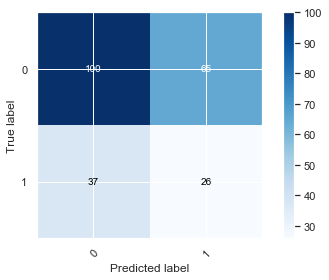

TPR = 0.4126984126984127, FPR = 0.3939393939393939, Precision = 0.2857142857142857


In [28]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

## RandomForestClassifier  (Smote)

In [29]:
clf = RandomForestClassifier(n_estimators=2000, max_depth=3)
clf.fit(X_train, y_train) 
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_scoer_train = clf.predict_proba(X_train)
y_scoer_test =  clf.predict_proba(X_test)
print(clf.feature_importances_)
print(f'accuracy score train: {accuracy_score(y_train, y_pred_train)}')
print(f'accuracy score test: {accuracy_score(y_test, y_pred_test)}')

[1.26706901e-02 7.64317477e-03 7.59611191e-03 9.50249049e-03
 3.15806902e-02 5.32399216e-03 7.92592409e-02 9.65501925e-03
 3.82051625e-03 5.84645236e-03 4.94746844e-03 5.72061614e-03
 1.13328332e-02 1.19990885e-02 6.94255854e-03 3.59506252e-02
 2.11011829e-02 4.84863667e-03 5.95566860e-03 5.72758656e-03
 1.20092316e-02 2.37331873e-02 4.73517128e-05 3.56988803e-03
 4.48988377e-03 5.88179896e-03 5.42448115e-03 2.14135966e-02
 6.54810009e-03 1.84528879e-02 5.69095986e-03 6.28973276e-03
 4.81902099e-03 4.84936913e-03 5.74469481e-03 7.45122675e-03
 7.20815293e-03 5.13087058e-03 1.16742129e-02 9.11305630e-03
 7.04680668e-03 1.45421248e-02 5.51991523e-02 6.14027234e-03
 5.00332823e-03 1.26238331e-02 2.02811207e-02 1.50637311e-02
 1.18313566e-02 3.13035094e-02 2.31546411e-02 5.66381938e-03
 3.81275886e-03 9.00723661e-03 8.99032650e-03 1.57717925e-02
 1.31365197e-02 6.51947952e-03 1.50917374e-02 7.16430798e-02
 1.77823522e-02 5.17123237e-02 6.89093449e-02 2.60503152e-02
 2.67526905e-02]
accurac

Accuracy is 61.8421052631579 %


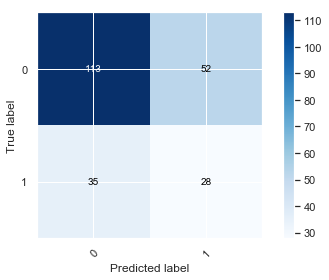

TPR = 0.4444444444444444, FPR = 0.3151515151515151, Precision = 0.35


In [30]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred_test)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")

## AdaBoost Classifier (Smote)

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
adb = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)  

y_pred_train_adb = adb.predict(X_train)
y_pred_test_adb = adb.predict(X_test)
y_scoer_train_adb = adb.predict_proba(X_train)
y_scoer_test_adb =  adb.predict_proba(X_test)
print(adb.feature_importances_)
print(f'accuracy score train: {accuracy_score(y_train, y_pred_train)}')
print(f'accuracy score test: {accuracy_score(y_test, y_pred_test)}')


[0.02 0.03 0.01 0.01 0.   0.   0.03 0.01 0.02 0.01 0.   0.01 0.   0.01
 0.02 0.02 0.01 0.   0.01 0.01 0.03 0.03 0.   0.   0.01 0.02 0.01 0.07
 0.01 0.02 0.   0.   0.02 0.   0.   0.01 0.02 0.01 0.02 0.03 0.   0.02
 0.02 0.   0.   0.   0.03 0.01 0.   0.14 0.   0.03 0.   0.01 0.   0.01
 0.01 0.   0.02 0.02 0.   0.05 0.04 0.02 0.03]
accuracy score train: 0.7883211678832117
accuracy score test: 0.618421052631579


Accuracy is 66.22807017543859 %


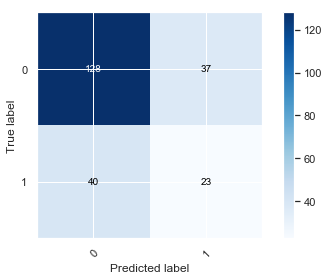

TPR = 0.36507936507936506, FPR = 0.22424242424242424, Precision = 0.38333333333333336


In [32]:
acc, tpr, fpr, precision = plot_confusion_matrix(y_test, y_pred_test_adb)
plt.show()
print(f"TPR = {tpr}, FPR = {fpr}, Precision = {precision}")